 This notebook is to calibrate SNe Ia and and calcualte H0.  

In [15]:
# Importing necessary libraries 
import sys
import numpy as np
import emcee
import astropy.io.fits as pyfits
import matplotlib.pylab as pl
import random,os
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
from astropy.io import ascii
import corner


Defining computing resources

In [16]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
os.environ["OMP_NUM_THREADS"] = "1"

12 CPUs


Read files containing calibrators and distant SNe Ia. All files are at ../data/working/ directory

In [17]:
file = 'B_ceph.csv' # change the filaname here if needed for other bands or for other calibrators
tab = ascii.read('../data/working/'+file)

In [18]:
c = 300000.
q=-0.53


Here we select sample from the original sample

In [19]:
# Excluding peculiar events
w = np.where((tab['sn']!='CSP14abk') &  (tab['sn']!='PTF13dyt') &  (tab['sn']!='PTF13dym') &  (tab['sn']!='PS1-13eao') & (tab['subtype']!='Ia-SC') & (tab['subtype']!='Ia-02cx') & (tab['sn']!='1981B') & (tab['sn']!='SN2012fr') & (tab['sn']!='1991T'))

# Excluding peculiar events + 91T and 91bg
#w = np.where((tab['sn']!='CSP14abk') &  (tab['sn']!='PTF13dyt') &  (tab['sn']!='PTF13dym') &  (tab['sn']!='PS1-13eao') & (tab['subtype']!='Ia-91T')& (tab['subtype']!='Ia-91bg'))


Reading all parameters from the input file and marking distance hosts.

In [20]:
# LC and host
st = tab['st'][w]
est = tab['est'][w]
zhel = tab['zhel'][w]
zcmb = tab['zcmb'][w]
mmax = tab['Mmax'][w]
emmax = tab['eMmax'][w]
bv =tab['BV'][w]
ebv = tab['eBV'][w]
m_csp = tab['m'][w]
eml = (tab['m'][w]-tab['ml'][w])
emu = (tab['mu'][w]-tab['m'][w])
em = (emu+eml)/2.

dist = tab['dist'][w]
edist = tab['edist'][w]
c_ms = tab['covMs'][w]
c_mbv = tab['covBV_M'][w]
sn = tab['sn'][w]
cal = tab['caltype'][w]

Ho_dists = (dist < 0)
#Ho_dists = (cal =='s')
#print (file, len(st), len(st[Ho_dists]))

ss= np.where(dist>0)
print (file, len(st[ss]))

B_ceph.csv 18


In [21]:
#initial guess
plim=-19.3, -19.2
p1lim =-1.2,-1.1
p2lim=-.055,-0.05
rvlim =2.7,2.71
alphalim=-0.11,-0.1
siglim=0.1,.12
vellim =300.,310
h0lim= 71.0,71.1

In [22]:
# Eqn 9 of Bruns 2018
def distmod(h,z1,z2):
    t1 = (1+z1)/(1+z2)
    t2 = (c*z2)/h
    t3 = 1 + (((1-q)/2)*z2)
    return (5*np.log10(t1*t2*t3)) +25


In [23]:
# Liklihood function
def like(par):
    p,p1,p2,rv,alpha,sig,vel,h0 = par
    if  -25.0<p<14.0  and -10.0<p1<10.0 and -10.0<p2<10.0 and 0.<rv<10.0 and -1.<alpha<1. and 0.<sig<1. and 0.<vel<1000. and  0< h0 < 1000.0: # priors
        

        
        mu_obs = mmax - p - p1*(st - 1.) -  p2*(st - 1.)**2 - rv*bv - alpha*(m_csp-np.median(m_csp))
        #mu_obs = mmax - p - p1*(st - 1.) -  p2*(st - 1.)**2 - rv*bv - (alpha*m_csp) # slope 


        mu_model = np.where(Ho_dists, distmod(h0,zhel,zcmb), dist)

        fac= (p1+(2*p2*st))
        velterm = (2.17*vel)**2/(c*zcmb)**2
        err = (fac*est)**2 +emmax**2 +(rv*ebv)**2+2*fac*c_ms+rv*c_mbv+sig**2+(0.00000723*vel/zcmb)**2 +(alpha*em)**2
        err1 = ((fac*est)**2) +(emmax**2) +((rv*ebv)**2)+(2*fac*c_ms)+(rv*c_mbv)+(edist**2)+(alpha*em)**2#
    
        mu_stat = np.where(Ho_dists,err,err1)

      
        mu_stat=np.sqrt(mu_stat)
        dmu=mu_obs-mu_model
        
        chi =np.sum((dmu)**2/mu_stat**2)
        return -0.5*chi - (0.5*np.sum(np.log(2*np.pi*(mu_stat)**2))) 
    else:
        return -np.inf

In [24]:
# EMCEE
ndim, nwalkers = 8, 80
ssize=1000
burnin = 200


p00 = np.random.rand(nwalkers) * (plim[1] - plim[0]) + plim[0]
p10 = np.random.rand(nwalkers) * (p1lim[1] - p1lim[0]) + p1lim[0]
p20 = np.random.rand(nwalkers) * (p2lim[1] - p2lim[0]) + p2lim[0]
rv0 = np.random.rand(nwalkers) * (rvlim[1] - rvlim[0]) + rvlim[0]
alpha0 = np.random.rand(nwalkers) * (alphalim[1] - alphalim[0]) + alphalim[0]
sig0 = np.random.rand(nwalkers) * (siglim[1] - siglim[0]) + siglim[0]
vel0 = np.random.rand(nwalkers) * (vellim[1] - vellim[0]) + vellim[0]
h00 = np.random.rand(nwalkers) * (h0lim[1] - h0lim[0]) + h0lim[0]

#p0 = zip(*[p00,p10,p20,rv0,alpha0,sig0,vel0,h00])
p0 = np.array([p00,p10,p20,rv0,alpha0,sig0,vel0,h00]).T

In [25]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, like)
print ("running mcmc on "+file)
start = time.time()
sampler.run_mcmc(p0,ssize,progress=True)
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
end = time.time()
serial_time = end - start

running mcmc on B_ceph.csv


100%|██████████| 1000/1000 [01:15<00:00, 13.19it/s]


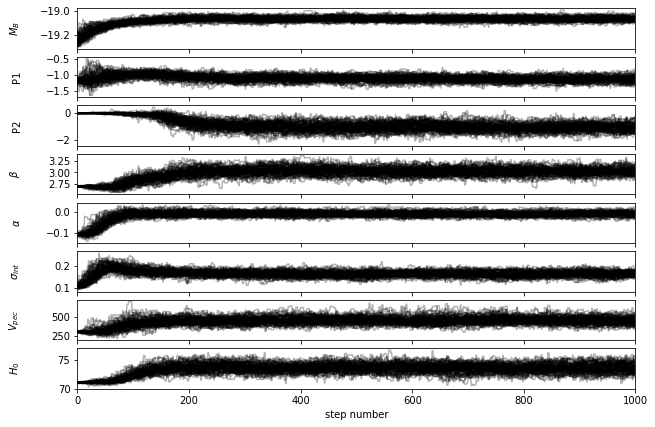

In [26]:
# Chains
fig, axes = pl.subplots(8, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$M_B$","P1", "P2", r"$\beta$",r"$\alpha$", r"$\sigma_{int}$",r"$V_{pec}$", r"$H_0$"]
for j in range(ndim):
    ax = axes[j]
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

#fig.savefig("../plots/steps_"+file[:-4]+"_"+str(nwalkers)+"_"+str(ssize)+".pdf")

samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))


In [27]:
# Printing results
p0_mcmc,p1_mcmc,p2_mcmc,rv_mcmc,alpha_mcmc,sig_mcmc,vel_mcmc, H0_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))


print("""MCMC result:
    P0 = {0[0]} +{0[1]} -{0[2]} 
    P1 = {1[0]} +{1[1]} -{1[2]} 
    P2 = {2[0]} +{2[1]} -{2[2]} 
    Beta = {3[0]} +{3[1]} -{3[2]}
    Alpha = {4[0]} +{4[1]} -{4[2]}
    Sigma = {5[0]} +{5[1]} -{5[2]}
    Vpec = {6[0]} +{6[1]} -{6[2]}
    H0 = {7[0]} +{7[1]} -{7[2]}

   
""".format(p0_mcmc, p1_mcmc, p2_mcmc,rv_mcmc,alpha_mcmc,sig_mcmc,vel_mcmc, H0_mcmc))


MCMC result:
    P0 = -19.06349375963127 +0.01828704761123845 -0.018353949705652184 
    P1 = -1.1098939287045986 +0.09016029199027842 -0.08871030242428413 
    P2 = -1.0537913291938859 +0.32225498942878006 -0.29699739302309736 
    Beta = 3.026526285057991 +0.08256377457017772 -0.08366400328186607
    Alpha = -0.010524365848208957 +0.010843370540838611 -0.010434368613447738
    Sigma = 0.16266792315961562 +0.013479967525962977 -0.012040783502262759
    Vpec = 450.605064331787 +46.633632128287616 -44.329636821329814
    H0 = 73.64198136590575 +0.7555403039760478 -0.7682522492352177

   



Mean acceptance fraction: 0.46358749999999993
Serial took 1.3 minutes


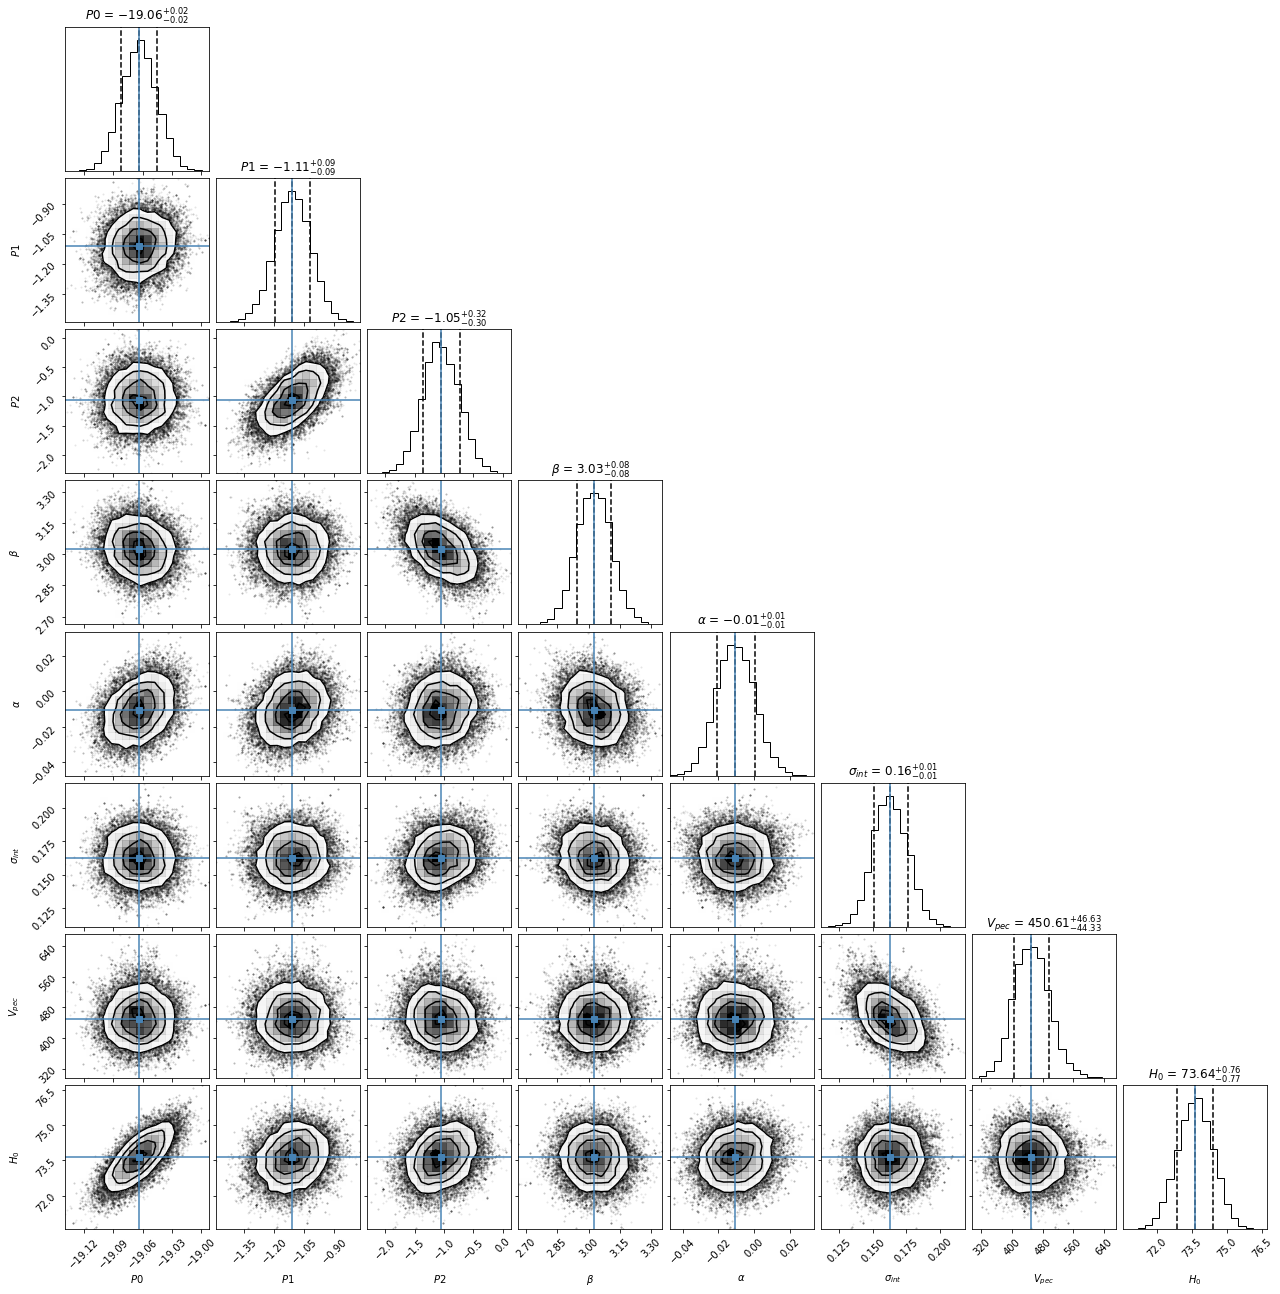

In [28]:
print ("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))

# Corner plot
figure = corner.corner(samples,labels=["$P0$","$P1$", "$P2$", r"$\beta$",r"$\alpha$", r"$\sigma_{int}$","$V_{pec}$", r"$H_0$"],quantiles=[0.16, 0.5, 0.84],truths=[p0_mcmc[0],p1_mcmc[0],p2_mcmc[0],rv_mcmc[0],alpha_mcmc[0],sig_mcmc[0],vel_mcmc[0],H0_mcmc[0]],show_titles=True)

print("Serial took {0:.1f} minutes".format(serial_time/60.))